## Introduction

Import required libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import colors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict

Provide the path to the file containing the data

In [2]:
path_to_csv = "data/abalone.csv"

We are using a third party graphing library called seaborn. To give all our graphs a good background we run the code below.

In [3]:
sns.set(rc={'figure.figsize':(11,8)})

Load the data into pandas. The data contains the following

| <p align="left">Name</p>           | <p align="left">Units</p>   | <p align="left">Description</p>      |
|:-----------------------------------|:-------:|:---------------------------------------------------------|
| <p align="left">Sex</p>            |         | <p align="left">M (male), F (female), and I (infant)</p> |
| <p align="left">Length</p>         | mm      | <p align="left">Longest shell measurement</p>            |
| <p align="left">Diameter</p>       | mm      | <p align="left">Perpendicular to length</p>              |
| <p align="left">Height</p>         | mm      | <p align="left">With meat in shell</p>                   |
| <p align="left">Whole Weight</p>   | grams   | <p align="left">Whole abalone</p>                        |
| <p align="left">Shucked weight</p> | grams   | <p align="left">Weight of meat</p>                       |
| <p align="left">Viscera weight</p> | grams   | <p align="left">Gut weight (after bleeding)</p>          |
| <p align="left">Shell weight</p>   | grams   | <p align="left">After being dried</p>                    |
| <p align="left">Rings</p>          |         | <p align="left">+1.5 gives the age in years</p>          |

In [4]:
df = pd.read_csv(path_to_csv, header=None, names = ["Sex", "Length", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Rings"])

Lets take a look at the data

In [5]:
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Missing Data


In [6]:
df.shape

(4177, 9)

We have now dropped the indexes, lets see if the dataframe has reduced by 3

In [7]:
df.shape

(4177, 9)

We can see above that the row length has reduced from 4177 to 4174. This is a difference of exactly 3 rows.

Lets check all our column types are correct

In [8]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings              object
dtype: object

Rings seems to have been assigned the wrong datatype. We can convery it to an object using the code below

In [9]:
df['Rings'] = pd.to_numeric(df['Rings'], errors='coerce')
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings             float64
dtype: object

Lets do a search for missing data. We can do this easily with pandas using the code below.

In [10]:
nans = df[df.isnull().any(axis=1)]
nans

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9.0
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11.0
3466,M,0.640,0.500,0.170,1.4545,0.6420,0.3575,0.3540,NaN


As can be seen from the results of our search we have 3 NaN rows. 

- Row 878 has an invalid Viscera weight
- row 1888 has an invalid Rings value 
- row 3093 has an invalid Sex value

We can now drop the indexes that are invalid from our dataframe. Before we do that lets display the size of our data frame before and after to confirm that the 3 rows were dropped

In [11]:
df.drop(df.index[df.isnull().any(axis=1)], inplace=True)

# Erroneous Data

Lets first check for zero value numbers. It would be impossible for example to have zero length or height

In [12]:
df[(df.select_dtypes(include=['number']) <= 0).any(1)]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1257,I,0.430,0.34,0.000,0.4280,0.2065,0.0860,0.1150,8.0
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.1690,0.2450,10.0
3996,I,0.315,0.23,0.000,0.1340,0.0575,0.0285,0.3505,6.0


Based on the above we can see that it would be impossible to have a height of zero or a minus diameter. We should remove rows 1257, 2758 and 3996, as they may skew our results.

In [13]:
df.drop(df.index[df['Height'] <= 0], inplace=True)
df.drop(df.index[df['Diameter'] <= 0], inplace=True)

In [14]:
df.shape

(4170, 9)

We have successfully dropped the 2 rows, next lets make sure all values in our Sex column are upper case for consistency. We will also remove any trailing whitespace which has been put in the Sex column unintentionally 

In [15]:
df['Sex'].str.upper()   # Make sure everything in the Sex column is uppercase
df['Sex'].str.strip()   # Strip whitespace from Sex column
df.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0


Because shucked weight is defined as weight without the shell. We should check if our data contains data where shucked weight is greater than the whole weight, which should not be possible. 

Lets create a scatter plot of shucked weight vs whole weight for quick visual inspection


Text(0.5,1,'Shucked Weight VS Whole Weight')

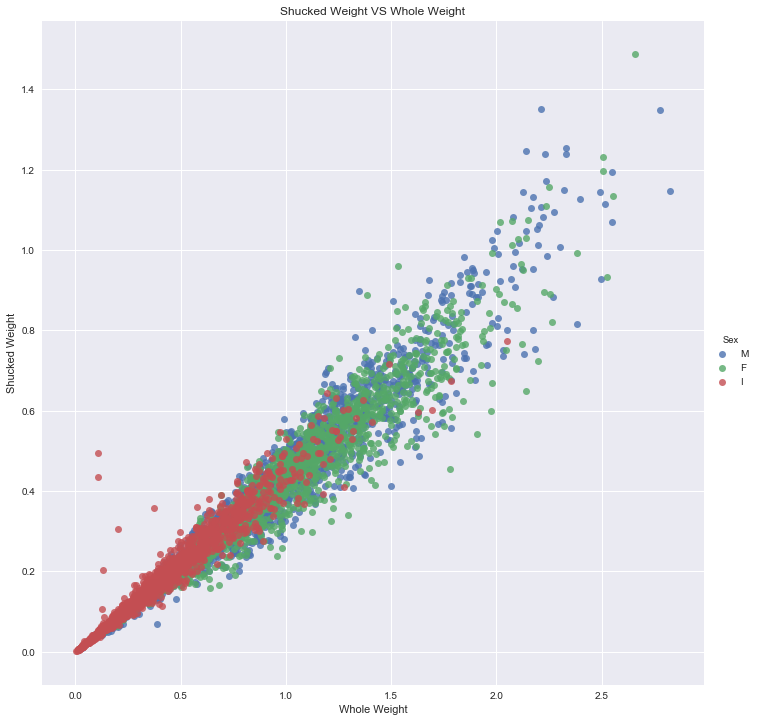

In [16]:
sns.lmplot("Whole Weight", "Shucked Weight", data=df, hue='Sex', fit_reg=False, size=10)
ax = plt.gca()
ax.set_title("Shucked Weight VS Whole Weight")

In the bottom left it seems we have some infants whose shucked weight is greater than the whole weight. 
We can get the exact rows using the formula below

In [17]:
df[df['Shucked Weight'] > df['Whole Weight']]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5.0
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5.0
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7.0
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7.0


Lets remove these rows

In [18]:
df.drop(df.index[df['Shucked Weight'] > df['Whole Weight']], inplace=True)

In [19]:
df.shape

(4166, 9)

Text(0.5,1,'Box Plot')

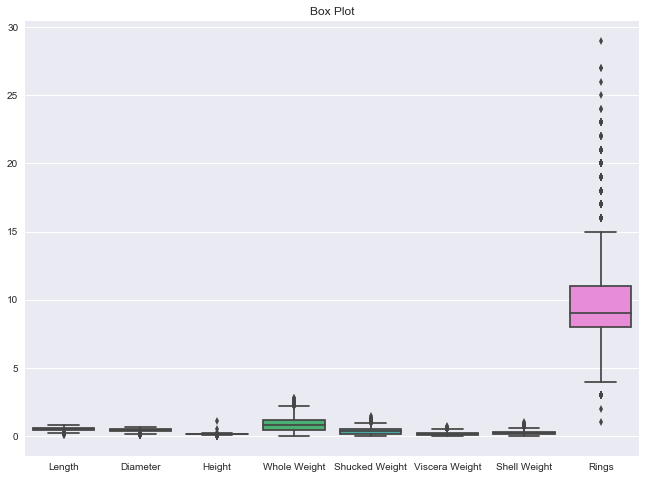

In [20]:
sns.boxplot(data=df).set_title("Box Plot")

Text(0.5,1,'Box Plot For Rings')

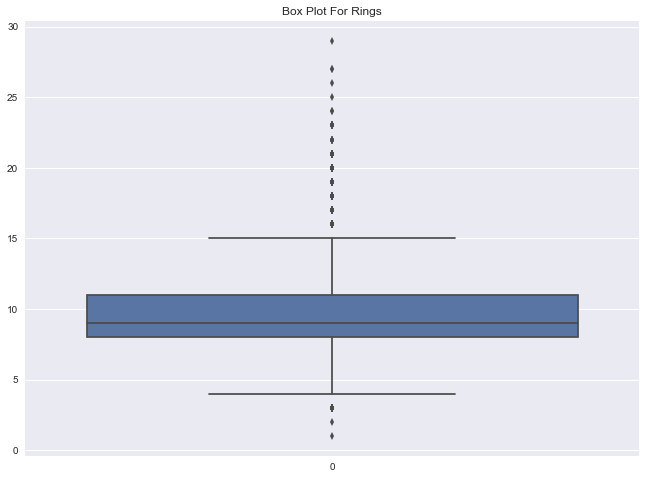

In [21]:
sns.boxplot(data=df['Rings']).set_title("Box Plot For Rings")

In [22]:
df.drop(df.index[(df['Rings'] > 15) | (df['Rings'] < 4)], inplace=True)

In [23]:
df.shape

(3888, 9)

# Scatter Plot

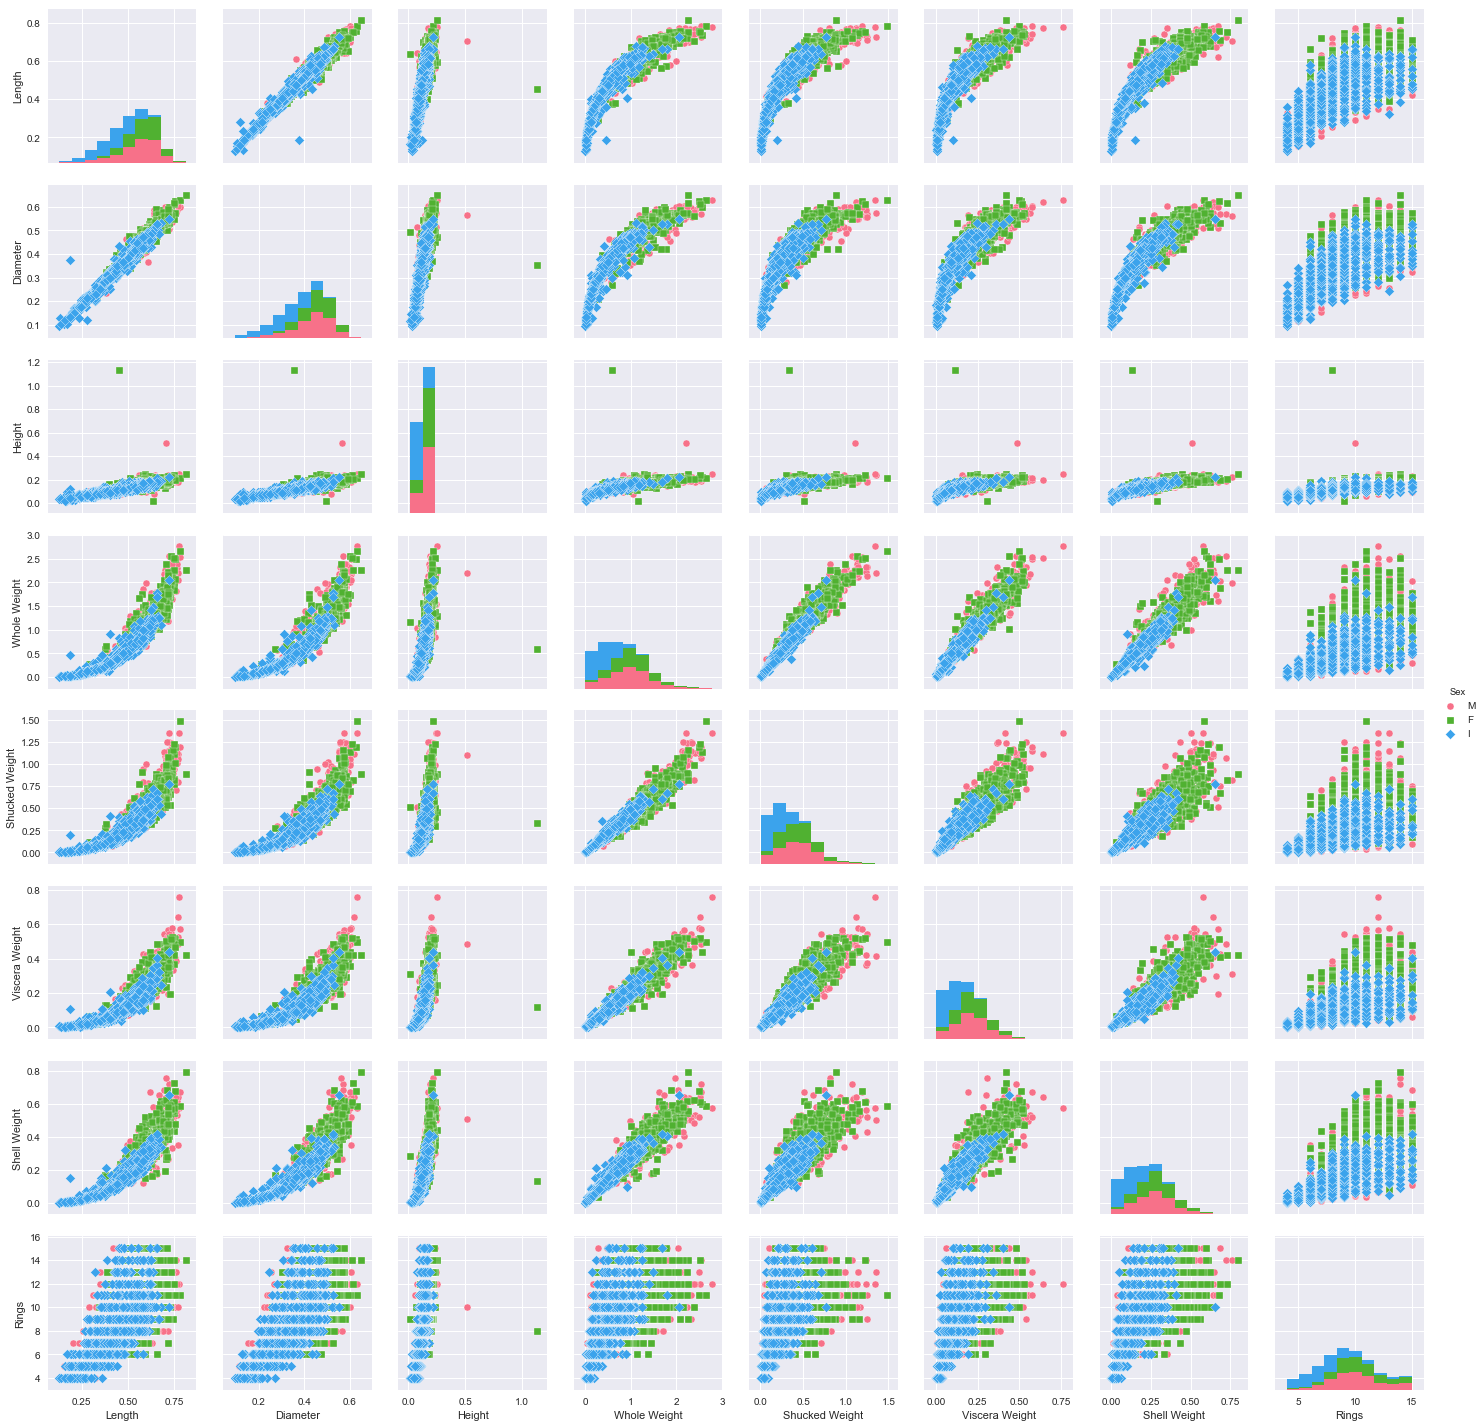

In [24]:
sns.pairplot(df, hue="Sex", palette="husl", markers=["o", "s", "D"])

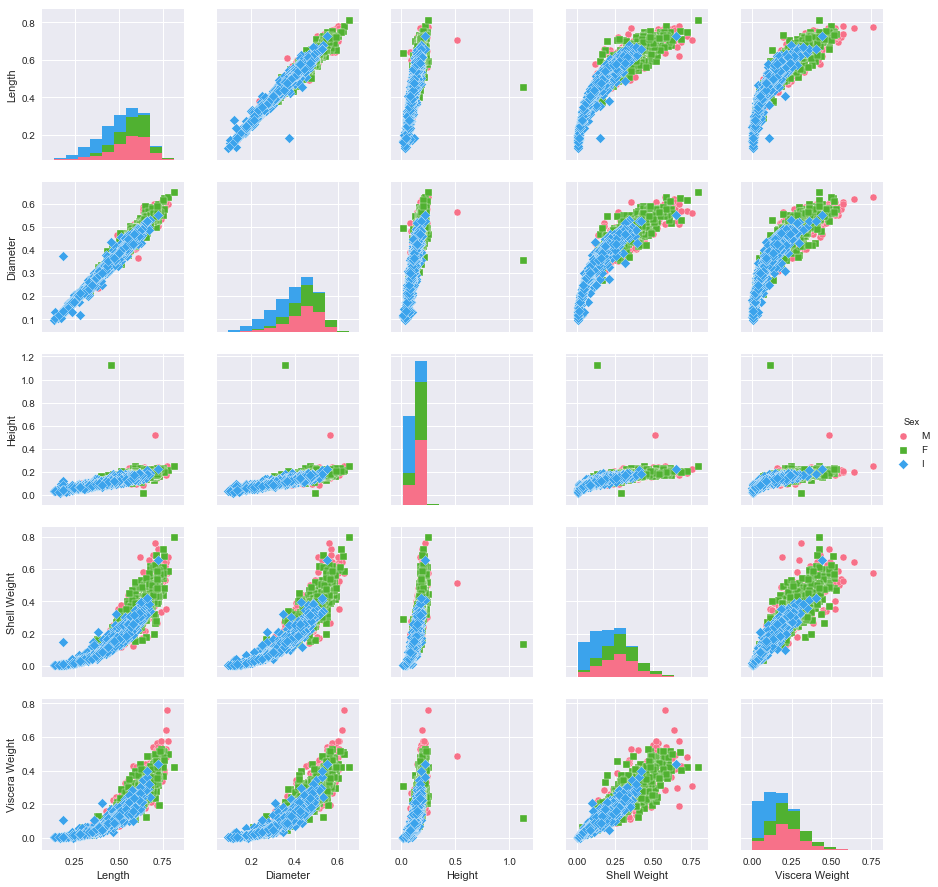

In [25]:
sns.pairplot(df[['Sex', 'Length', 'Diameter', 'Height', 'Shell Weight', 'Viscera Weight']], hue="Sex", palette="husl", markers=["o", "s", "D"])

In [26]:
#corr = df[['Sex', 'Length', 'Diameter', 'Height', 'Shell Weight', 'Viscera Weight']].corr()
#c1 = corr.abs().unstack()
#c1.sort_values(ascending = False)

print("Correlation Matrix")
print(df.corr())
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Rings']], 20))

Correlation Matrix
                  Length  Diameter    Height  Whole Weight  Shucked Weight  \
Length          1.000000  0.986704  0.821491      0.928779        0.902566   
Diameter        0.986704  1.000000  0.826795      0.927698        0.897396   
Height          0.821491  0.826795  1.000000      0.814160        0.777994   
Whole Weight    0.928779  0.927698  0.814160      1.000000        0.976042   
Shucked Weight  0.902566  0.897396  0.777994      0.976042        1.000000   
Viscera Weight  0.905639  0.901341  0.796255      0.968562        0.935259   
Shell Weight    0.916230  0.922483  0.819464      0.962920        0.907068   
Rings           0.618564  0.633749  0.580825      0.575428        0.490953   

                Viscera Weight  Shell Weight     Rings  
Length                0.905639      0.916230  0.618564  
Diameter              0.901341      0.922483  0.633749  
Height                0.796255      0.819464  0.580825  
Whole Weight          0.968562      0.962920  0.57

# Linear Regression Model

Lets build a regression model for the abalone dataset. The regression model will predict the number of rings of an abalone

### One hot encoding

Because regression can only work on numeric values we are going to have to use a technique called one hot encoding to convert our Sex column into numeric data

In [27]:
df['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [28]:
encoded_sex = pd.get_dummies(df['Sex'])
df = pd.concat([df, encoded_sex], axis='columns')
df = df.drop('Sex', axis='columns')

df.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,0,1,0


Notice the Sex column has been dropped and we now see 3 new columns for the sex. These are M, F, I (Male, Female, Infant). 

### Dummy model
Next lets prepare a dummy regression model. As mentioned in the lab notes, these are very naive (often incorrect) predictions about the target variable. This is a good first step as it gives us a benchmark to compare our later models to.

Mean absolute error: 1.910076
Standard deviation of the error: 2.384775


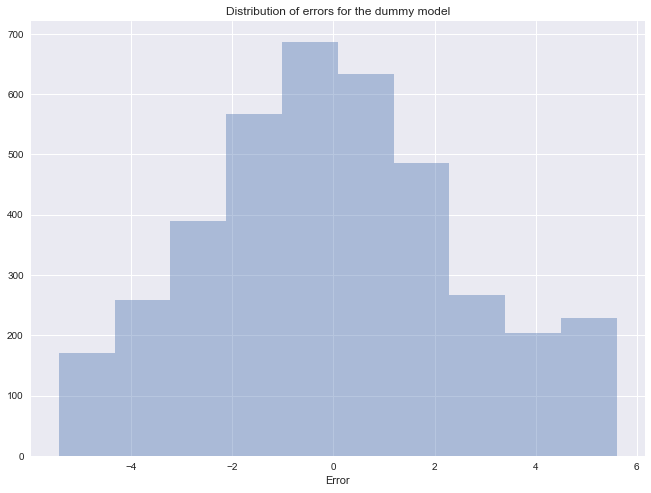

In [53]:
X = df.drop('Rings', axis='columns')  # X = features
y = df['Rings']                       # y = prediction target
model = DummyRegressor()
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5 fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

print('Mean absolute error: %f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

ax = sns.distplot(y - y_pred, bins=10, kde=False)

# ax = (y - y_pred).hist()

ax.set(
    title='Distribution of errors for the dummy model',
    xlabel='Error'
);

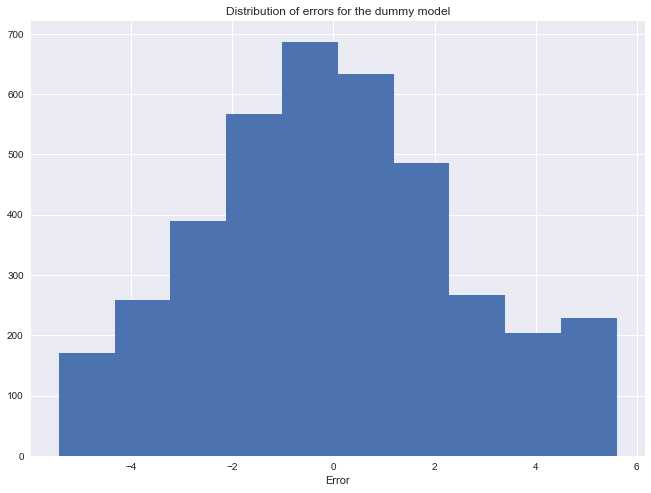

In [40]:

# ax = sns.distplot(y - y_pred, bins=10)

ax = (y - y_pred).hist()

ax.set(
    title='Distribution of errors for the dummy model',
    xlabel='Error'
);

### Linear regression model

Mean absolute error: 1.269715
Standard deviation of the error: 1.661693


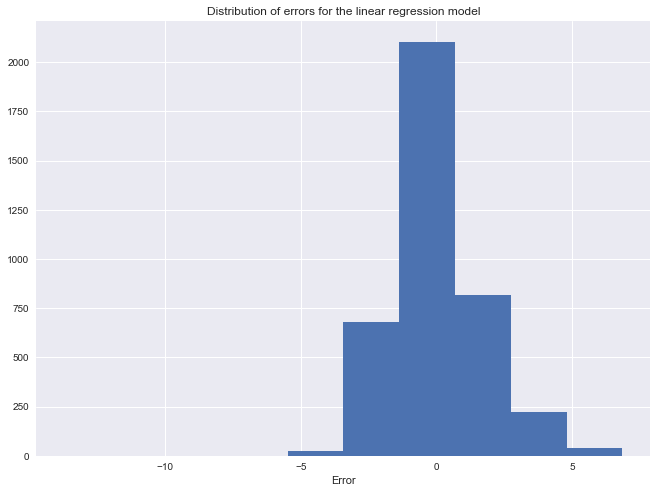

In [30]:
X = df.drop('Rings', axis='columns')  # X = features
y = df['Rings']                       # y = prediction target

model = LinearRegression(fit_intercept=True, normalize=False)  # Use least squares linear regression

outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5-fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

print('Mean absolute error: %f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

ax = (y - y_pred).hist()
ax.set(
    title='Distribution of errors for the linear regression model',
    xlabel='Error'
);